In [ ]:
import os
import random
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# import torchvision
from skimage import io
from skimage.io import imread

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>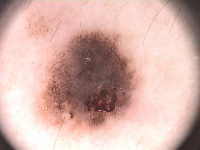</td><td>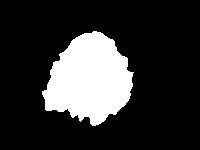</td></tr></table>


Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
root = 'PH2Dataset'

RESCALE_SIZE = (256, 256)

IMAGES = []
LESIONS = []

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
  for name in files:
    file_path = os.path.join(root, name)
    if root.endswith('_Dermoscopic_Image'):
        IMAGES.append(imread(file_path))

    if root.endswith('_lesion'):
        LESIONS.append(imread(file_path))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
X = [resize(x, RESCALE_SIZE, mode='constant', anti_aliasing=True) for x in IMAGES]
Y = [resize(y, RESCALE_SIZE, mode='constant', anti_aliasing=False) > 0.5 for y in LESIONS]

In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)}, {len(Y)} images')

Loaded 200, 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

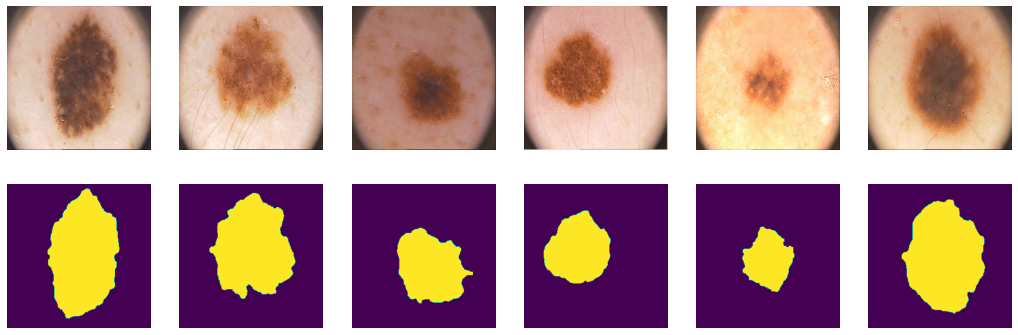

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
np.random.seed(42) #seed для фиксации разделения
len_common = len(X)
ix = np.random.choice(len_common, len_common, False)
tr, val, ts = np.split(ix, [100, 150])

### PyTorch DataLoader

In [ ]:
n_classes = 1
BATCH_SIZE = 6

dl_train = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=BATCH_SIZE, shuffle=True)
dl_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=BATCH_SIZE, shuffle=False)
dl_test = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=BATCH_SIZE, shuffle=False)

###  Отрисовка нескольких картинок из batch'a

In [ ]:
def show_batch(x_batch, y_pred, y_batch):
    plt.figure(figsize=(18, 6))
    num_show = 6

    for i in range(num_show):
        
        plt.subplot(3, num_show, i + 1)
        plt.imshow(np.rollaxis(x_batch[i].numpy(), 0, 3), cmap='gray')
        plt.title('image')
        plt.axis('off')

        plt.subplot(3, num_show, i + 1 + num_show)
        plt.imshow(y_pred[i, 0] > 0.5, cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(3, num_show, i + 1 + 2* num_show)
        plt.imshow(y_batch[i, 0].cpu().numpy(), cmap='gray')
        plt.title('Target')
        plt.axis('off')
    plt.show()

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs > 0.5
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded.mean().item()

Тренировка 

In [ ]:
def train(model, opt, criterion, metric, epoch_start, epoch_end, dl_train, dl_val):
    log_template = "\nEpoch {:3} train_loss: {:.4f} val_loss {:.4f} train_score {:.4f} val_score {:.4f}"
    train_losses, train_scores, val_losses, val_scores = [], [], [], []

    num_train = len(dl_train)
    num_val = len(dl_val)
    
    for epoch in range(epoch_start, epoch_end):
        model.train()  # train mode
        loss_sum = 0
        scores = 0

        for x_batch, y_batch in dl_train:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            opt.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch) 
            loss.backward() 
            opt.step()  
            loss_sum += loss.item()
            scores += metric(y_pred, y_batch)

        train_loss = loss_sum / num_train
        train_score = scores / num_train

        model.eval() 
        loss_sum = 0
        scores = 0

        with torch.no_grad():
            for x_batch, y_batch in dl_val:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                loss_sum += loss.item()
                scores += metric(y_pred, y_batch)

        val_loss = loss_sum / num_val
        val_score = scores / num_val
        train_losses.append(train_loss)
        train_scores.append(train_score)
        val_losses.append(val_loss)
        val_scores.append(val_score)
        print(log_template.format(epoch+1, train_loss, val_loss, train_score, val_score))
            
    return train_losses, train_scores, val_losses, val_scores

## Тестирование

In [ ]:
def test(model, criterion, metric, dl_test, show=True):

    num_test = len(dl_test)
    model.eval() 
    loss_sum = 0
    scores = 0

    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(dl_test):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss_sum += loss.item()

            scores += metric(y_pred, y_batch)

            x_batch =  x_batch.cpu().detach() 
            y_pred = y_pred.cpu().detach()

            if show and not i:
                show_batch(x_batch, y_pred, y_batch)

    test_loss = loss_sum / num_test
    test_score = scores / num_test
    print( "test_loss: {:.4f} test_score {:.4f}".format(test_loss, test_score))

In [ ]:
def plot_trainig(train_losses, train_scores, val_losses, val_scores):
    plt.figure(figsize=(16, 12))
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel('epoch')
    plt.plot(train_scores, label='train score')
    plt.plot(val_scores, label='val score')
    plt.title('Score')
    plt.legend()

In [ ]:
def print_best_epoch(history): 
    val_losses = history[2]
    val_scores = history[3]
    e1 = np.asarray(val_losses).argmin()
    e2 = np.asarray(val_scores).argmax()
    print("{:>10} {:>15} {:>15}".format('best epoch','min val loss','max val score'))
    if e1 != e2:
        print("{:>10} {:>15.4f} {:>15.4f}".format(e1 + 1, val_losses[e1], val_scores[e1]))
    print("{:>10} {:>15.4f} {:>15.4f}".format(e2 + 1, val_losses[e2], val_scores[e2]))

In [ ]:
history_transform = ([],[],[],[])
def extend_history(history_full, history, reset=False):
    for i in range(len(history_full)):
      if reset:
          history_full[i].clear()
      history_full[i].extend(history[i])

In [ ]:
def dice_loss(y_real, y_pred):  
    SMOOTH = 1
    y_pred = torch.sigmoid(y_pred)
    num = 2*y_real*y_pred 
    den = y_real + y_pred
    res = (num + SMOOTH)/(den + SMOOTH)
    res = 1 - torch.mean(res, dim=(1, 2, 3))
    return torch.mean(res)

### Модули трансформера

In [ ]:
class Tokenizer(nn.Module):
    def __init__(self, L, CT, C, head=16, groups=16, dynamic=False):
        # CT = num_channels previous Tokenizer(starts from 2)
        super(Tokenizer, self).__init__()
        if not dynamic:
            # use static weights to compute token coefficients .
            self.conv_token_coef = nn.Conv2d(C, L, kernel_size=1)
        else:
            # use previous tokens to compute a query weight , which is
            # then used to compute token coefficients .
            self.conv_query = nn.Conv1d(CT, C, kernel_size=1)
            self.conv_key = nn.Conv2d(C, C, groups=groups, kernel_size=1)

        self.conv_value = nn.Sequential(
                                nn.Conv2d(C, C, groups=groups, kernel_size=1),
                                nn.BatchNorm2d(C),
                                nn.ReLU()
                                       )
        self.conv_token = nn.Sequential(
                                        nn.Conv1d(C, CT, kernel_size=1),
                                        nn.BatchNorm1d(CT),
                                        nn.ReLU()
                                        )

        self.head = head
        self.dynamic = dynamic
        

    def forward(self, feature, token=None):
        # compute token coefficients
        # feature : N, C, H, W, token : N, CT , L
        if not self.dynamic:
            token_coef = self.conv_token_coef(feature)  # N, L, H, W
            N, L, H, W = token_coef.shape
            token_coef = token_coef.view(N, 1, L, H * W)
            token_coef = token_coef.permute(0, 1, 3, 2)  # N, 1 , HW , L
            token_coef = token_coef / np.sqrt(feature.shape[1])
        else:
            L = token.shape[2]
            # Split input tokens
            # T_a , T_b: N, CT , L // 2
            T_a, T_b = token[:, :, : L // 2], token[:, :, L // 2:]           
            query = self.conv_query(T_a)
            N, C, L_a = query.shape
            # N, h, C//h, L_a
            query = query.view(N, self.head, C // self.head, L_a)
            N, C, H, W = feature.shape
            key = self.conv_key(feature).view(
                N, self.head, C // self.head, H * W)  # N, h, C // h, HW
            # Compute token coefficients .
            # N, h, HW , L_a
            token_coef = torch.matmul(key.permute(0, 1, 3, 2), query) 
            token_coef = token_coef / np.sqrt(C / self.head)

        N, C, H, W = feature.shape
        token_coef = F.softmax(token_coef, dim=2) # N, h, HW, L
        value = self.conv_value(feature).view(
            N, self.head, C // self.head, H * W)  # N, h, C // h, HW

        # extract tokens from the feature map
        # static tokens : N, C, L. dynamic tokens : N, C, L_a
        ### ((N, h, C // h, HW), N, h, HW, L) -> (N, h, C // h, L) -> (N, C, L)
        tokens = torch.matmul(value, token_coef,).view(N, C, -1)
        
        # compute position encoding
        # if static : pos_encoding : N, Cp , L else : N, Cp , L_a
        # pos_encoding = self.pos_encoding(token_coef, (H, W))
        # tokens = torch.cat((tokens, pos_encoding), dim=1)

        if not self.dynamic:
            # N, C+Cp , L -> N, CT , L ### N, C , L -> N, CT , L
            tokens = self.conv_token(tokens)
        else:
            # N, C+Cp , L_a -> N, CT , L_a , then cat to N, CT , (L_a + L_b ) ### N, C , L_a -> N, CT , L_a , then cat to N, CT , (L_a + L_b )
            tokens = torch.cat((T_b, self.conv_token(tokens)), dim=2)
        return tokens

In [ ]:
class ViTransformer(nn.Module):
    def __init__(self, CT, head, kqv_groups):
        super(ViTransformer, self).__init__()

        self.k_conv = nn.Conv1d(CT, CT // 2, groups=kqv_groups, kernel_size=1)
        self.q_conv = nn.Conv1d(CT, CT // 2, groups=kqv_groups, kernel_size=1)
        self.v_conv = nn.Conv1d(CT, CT, groups=kqv_groups, kernel_size=1)

        self.ff_conv = nn.Sequential(
                                    nn.Conv1d(CT, CT, groups=kqv_groups, 
                                              kernel_size=1),
                                    nn.BatchNorm1d(CT),
                                    nn.ReLU()
                                    )
        self.head = head
        self.CT = CT

    def forward(self, tokens):
        N = tokens.shape[0]
        # k: N, h, CT //2//h, L
        k = self.k_conv(tokens).view(
                                N, self.head, self.CT // 2 // self.head, -1)
        # q: N, h, CT //2//h, L
        q = self.q_conv(tokens).view(
                                N, self.head, self.CT // 2 // self.head, -1)
        # v: N, h, CT //h, L
        v = self.v_conv(tokens).view(
                                N, self.head, self.CT // self.head, -1)
        ### (N, h, L, CT //2//h) * (N, h, CT //2//h, L) -> (N, h, L, L)  
        kq = torch.matmul(k.permute(0, 1, 3, 2), q)
        kq = F.softmax(kq / np.sqrt(kq.shape[2]), dim=2) 
        # print(v.shape, kq.shape) #torch.Size([N, h, 9, 8]) torch.Size([N, h, 9, 9])

        ### (N, h, CT //h, L) * (N, h, L, L) -> (N, h, CT //h, L) -> (N, CT , L)
        kqv = torch.matmul(v, kq).view(N, self.CT, -1)
        tokens = tokens + kqv
        tokens = tokens + self.ff_conv(tokens)
        return tokens

In [ ]:
class Projector(nn.Module):
    def __init__(self, CT, C, head, groups, dropout):
        super(Projector, self).__init__()
        
        self.drop = nn.Dropout(dropout)
        self.proj_value_conv = nn.Conv1d(CT, C, kernel_size=1)
        self.proj_key_conv = nn.Conv1d(CT, C, kernel_size=1)

        self.proj_query_conv = nn.Sequential(
                                             nn.Conv2d(C, C, groups=groups, 
                                                      kernel_size=1),
                                             nn.BatchNorm2d(C),
                                             nn.ReLU()
                                             )
        self.head = head


    def forward(self, feature, token):
        N, _, L = token.shape 
        h = self.head                                                    
        ### proj_v : (N, h, C //h, L)                                               
        proj_v = self.proj_value_conv(token).view(N, h, -1, L)  
        ### proj_k : (N, h, C //h, L)            
        proj_k = self.proj_key_conv(token).view(N, h, -1, L)  
        proj_q = self.proj_query_conv(feature) ### (N, C, H, W)
        N, C, H, W = proj_q.shape                                        
        proj_q = proj_q.view(N, h, C // h, H * W).permute(0, 1, 3, 2)
        ### (N, h, H * W, C // h) * (N, h, C //h, L) -> (N, h, HW , L)
        # print(proj_q.shape, proj_k.shape, proj_v.shape)
        proj_coef = F.softmax(torch.matmul(proj_q, proj_k) / np.sqrt(C / h), dim=3)
        ### (N, h, C //h, L) * (N, h, L, HW) -> (N, h, C // h, HW)
        proj = torch.matmul(proj_v, proj_coef.permute(0, 1, 3, 2))

        _, _, H, W = feature.shape
        feature = F.relu(self.drop(feature))
        return feature + proj.view(N, -1, H, W)

### В данной модели для связи между энкодером и декодером не используется классический для архитектур Unet слой bottleneck с трансформацией feature_map - вместо него связь осуществляется посредством токенов через слой трансформера.
Идея отсюда (раздел 4) : https://arxiv.org/pdf/2006.03677.pdf

In [ ]:
class Transf_FPN(nn.Module):
    def __init__(self, L, CT, head=16, groups=16, dropout=0.5):
        super().__init__()

        self.enc0 = self.enc_block(3, 32)
        self.tokenizer0 = Tokenizer(L, CT, 32, head=16, groups=16)

        self.enc1 = self.enc_block(32, 64)
        self.tokenizer1 = Tokenizer(L, CT, 64, head=16, groups=16, dynamic=True)

        self.enc2 = self.enc_block(64, 128)
        self.tokenizer2 = Tokenizer(L, CT, 128, head=16, groups=16, dynamic=True)

        self.enc3 = self.enc_block(128, 256)
        self.tokenizer3 = Tokenizer(L, CT, 256, head=16, groups=16, dynamic=True)

        self.transf = ViTransformer(CT * 4, head, groups // 2)

        self.dec0 = Projector(CT, 256, head, groups, dropout)
        self.fpn_0 = self.fpn_block(256, 4)
        
        self.dec1 = Projector(CT, 128, head, groups, dropout)
        self.fpn_1 = self.fpn_block(128, 4)

        self.dec2 = Projector(CT, 64, head, groups, dropout)
        self.fpn_2 = self.fpn_block(64, 4)

        self.dec3 = Projector(CT, 32, head, groups, dropout)
        self.fpn_3 = self.fpn_block(32, 4)

        self.out = nn.Conv2d(16, 1, 1, 1)

    def forward(self, x):
        # encoder
        e0 = self.enc0(x)
        token0 = self.tokenizer0(e0)
        
        e1 = self.enc1(e0)
        token1 = self.tokenizer1(e1, token0)
        
        e2 = self.enc2(e1)
        token2 = self.tokenizer2(e2, token1)

        e3 = self.enc3(e2) 
        token3 = self.tokenizer3(e3, token2)

        # vis_transformer
        tokens = torch.cat([token0, token1, token2, token3], 1)
        tokens = self.transf(tokens)

        # decoder 
        N, h, L = token1.shape 

        d0 = self.dec0(e3, tokens[:, h*3:, :])  
        d0 = self.fpn_0(d0) # d0.shape torch.Size([6, 4, 16, 16])

        d1 = self.dec1(e2, tokens[:, h*2: h*3, :])  
        d1 = self.fpn_1(d1) # d1.shape torch.Size([6, 4, 32, 32])

        d2 = self.dec2(e1, tokens[:, h: h*2, :])  
        d2 = self.fpn_2(d2) # d2.shape torch.Size([6, 4, 64, 64])

        d3 = self.dec3(e0, tokens[:, :h, :])  
        d3 = self.fpn_3(d3) # d3.shape torch.Size([6, 4, 128, 128])

        out = torch.cat([F.interpolate(d0, size=256),
                         F.interpolate(d1, size=256),
                         F.interpolate(d2, size=256),
                         F.interpolate(d0, size=256)], dim=1)
        out = self.out(out)
        return out

    def enc_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        enc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, 1, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, 2, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return enc

    def fpn_block(self, in_channels, out_channels=4):
        enc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        return enc

In [ ]:
np.random.seed(0)
torch.set_deterministic(True)
torch.manual_seed(0)

fpn_transform = Transf_FPN(4, 256, 16, 16, dropout=0.5).to(device)

opt = torch.optim.AdamW(fpn_transform.parameters(), lr=3e-4, weight_decay=1e-2)

loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
history_transform = ([],[],[],[])
def extend_history(history_full, history, reset=False):
    for i in range(len(history_full)):
      if reset:
          history_full[i].clear()
      history_full[i].extend(history[i])

In [ ]:
start = time()
history = train(fpn_transform, opt, loss_fn, iou_pytorch, 0, 100, dl_train, dl_val)
print('Time of execution : ', time() - start)


Epoch   1 train_loss: 0.5827 val_loss 0.6322 train_score 0.3172 val_score 0.0000

Epoch   2 train_loss: 0.5055 val_loss 0.5492 train_score 0.5039 val_score 0.0000

Epoch   3 train_loss: 0.4723 val_loss 0.4218 train_score 0.5730 val_score 0.3833

Epoch   4 train_loss: 0.4569 val_loss 0.4157 train_score 0.6034 val_score 0.6241

Epoch   5 train_loss: 0.4395 val_loss 0.3842 train_score 0.6186 val_score 0.7167

Epoch   6 train_loss: 0.4269 val_loss 0.3950 train_score 0.6368 val_score 0.6870

Epoch   7 train_loss: 0.4210 val_loss 0.3617 train_score 0.5711 val_score 0.6315

Epoch   8 train_loss: 0.4018 val_loss 0.3381 train_score 0.6534 val_score 0.7148

Epoch   9 train_loss: 0.3920 val_loss 0.3878 train_score 0.6382 val_score 0.7574

Epoch  10 train_loss: 0.3781 val_loss 0.3175 train_score 0.6279 val_score 0.6574

Epoch  11 train_loss: 0.3742 val_loss 0.3225 train_score 0.6167 val_score 0.7519

Epoch  12 train_loss: 0.3598 val_loss 0.3193 train_score 0.6667 val_score 0.6704

Epoch  13 train

In [ ]:
extend_history(history_transform, history)

In [ ]:
opt = torch.optim.AdamW(fpn_transform.parameters(), lr=3e-5, weight_decay=1e-3,)
history = train(fpn_transform, opt, loss_fn, iou_pytorch, 101, 115, dl_train, dl_val)


Epoch 102 train_loss: 0.1028 val_loss 0.1190 train_score 0.8015 val_score 0.7648

Epoch 103 train_loss: 0.0906 val_loss 0.1150 train_score 0.8176 val_score 0.7741

Epoch 104 train_loss: 0.1130 val_loss 0.1161 train_score 0.8005 val_score 0.7907

Epoch 105 train_loss: 0.0902 val_loss 0.1141 train_score 0.8235 val_score 0.7852

Epoch 106 train_loss: 0.0930 val_loss 0.1176 train_score 0.8127 val_score 0.7630

Epoch 107 train_loss: 0.0834 val_loss 0.1168 train_score 0.8230 val_score 0.7796

Epoch 108 train_loss: 0.0841 val_loss 0.1139 train_score 0.8338 val_score 0.7796

Epoch 109 train_loss: 0.0932 val_loss 0.1136 train_score 0.8132 val_score 0.7778

Epoch 110 train_loss: 0.0832 val_loss 0.1160 train_score 0.8466 val_score 0.7833

Epoch 111 train_loss: 0.0821 val_loss 0.1170 train_score 0.8358 val_score 0.7796

Epoch 112 train_loss: 0.0849 val_loss 0.1114 train_score 0.8412 val_score 0.7796

Epoch 113 train_loss: 0.0795 val_loss 0.1099 train_score 0.8436 val_score 0.7889

Epoch 114 train

In [ ]:
extend_history(history_transform, history)

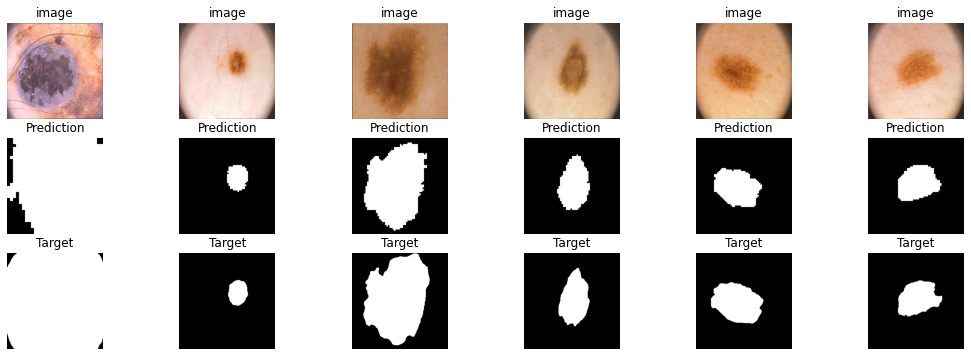

test_loss: 0.1224 test_score 0.7444


In [ ]:
test(fpn_transform, loss_fn, iou_pytorch, dl_test) 

In [ ]:
test(fpn_transform, loss_fn, iou_pytorch, dl_test, show=False) 

test_loss: 0.1224 test_score 0.7444


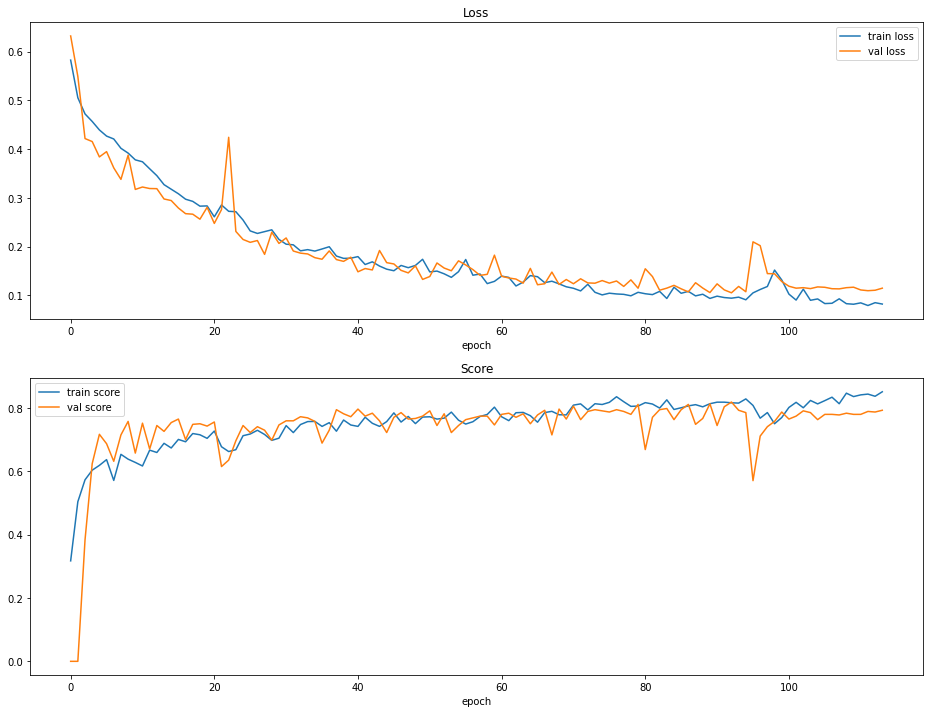

In [ ]:
plot_trainig(*history_transform)

### Следующий вариант - стандартный для Unet-FPN архитектур. Трансформер по сути подключен в параллель.

приносим извинения, что размерности захардкожены - сутки собирались к дедлайну по хаккатону, несколько поспешно.

In [ ]:
class Transf_Unet_FPN(nn.Module):
    def __init__(self, L, CT, head=16, groups=16, dropout=0.5):
        super().__init__()
        # encoder
        self.enc0 = self.enc_block(3, 32)
        self.tokenizer0 = Tokenizer(L, CT, 32, head=16, groups=16)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) 

        self.enc1 = self.enc_block(32, 64)
        self.tokenizer1 = Tokenizer(L, CT, 64, head=16, groups=16, dynamic=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc2 = self.enc_block(64, 128)
        self.tokenizer2 = Tokenizer(L, CT, 128, head=16, groups=16, dynamic=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc3 = self.enc_block(128, 256)
        self.tokenizer3 = Tokenizer(L, CT, 256, head=16, groups=16, dynamic=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # vis_transformer
        self.transf = ViTransformer(CT * 4, head, groups // 2)

        # bottleneck
        self.bottleneck_conv = self.bottleneck(256, 256)

        # decoder
        self.proj_0 = Projector(CT, 256, head, groups, dropout) # x16 -> fpn_0
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.fpn_0 = self.fpn_block(256, 4)

        self.dec1 = self.dec_block(256 * 2, 128)
        self.proj_1 = Projector(CT, 128, head, groups, dropout)
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.fpn_1 = self.fpn_block(128, 4)

        self.dec2 = self.dec_block(128 * 2, 64)
        self.proj_2 = Projector(CT, 64, head, groups, dropout)
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.fpn_2 = self.fpn_block(64, 4)

        self.dec3 = self.dec_block(64 * 2, 32)
        self.proj_3 = Projector(CT, 32, head, groups, dropout)
        self.fpn_3 = self.fpn_block(32, 4)

        self.out = nn.Conv2d(16, 1, 1, 1)

    def forward(self, x):                                         #  x :  N * 32 * 256 * 256
        # encoder
        e0 = self.enc0(x)                                         # N * 32 * 256 * 256
        e0_pool, ind0 = self.pool0(e0)                            # N * 32 * 128 * 128, N * 32 * 128 * 128
        token0 = self.tokenizer0(e0_pool)
        
        e1 = self.enc1(e0_pool)                                   # N * 64 * 128 * 128
        e1_pool, ind1 = self.pool1(e1)                            # N * 64 * 64 * 64, N * 64 * 64 * 64
        token1 = self.tokenizer1(e1_pool, token0)
        
        e2 = self.enc2(e1_pool)                                   # N * 128 * 64 * 64
        e2_pool, ind2 = self.pool2(e2)                            # N * 128 * 32 * 32, N * 128 * 32 * 32
        token2 = self.tokenizer2(e2_pool, token1)

        e3 = self.enc3(e2_pool)                                   # N * 256 * 32 * 32
        e3_pool, ind3 = self.pool3(e3)                            # N * 256 * 16 * 16
        token3 = self.tokenizer3(e3_pool, token2)

        # vis_transformer
        tokens = torch.cat([token0, token1, token2, token3], 1)
        tokens = self.transf(tokens)

        # bottleneck
        b = self.bottleneck_conv(e3_pool)                         # N * 256 * 16 * 16

        # decoder 
        _, h, _ = token1.shape 

        d0 = self.proj_0(b, tokens[:, h*3:, :])                   # N * 256 * 16 * 16
        fn0 = self.fpn_0(d0)                                      # fpn_0.shape torch.Size([6, 4, 16, 16])
        d_upsample_0 = self.upsample0(b, ind3)                    # N * 256 * 32 * 32

        d1 = self.dec1(torch.cat([e3, d_upsample_0], 1))          # N * 128 * 32 * 32
        d1 = self.proj_1(d1, tokens[:, h*2: h*3, :])              # N * 128 * 32 * 32
        fn1 = self.fpn_1(d1)                                      # d1.shape torch.Size([6, 4, 32, 32])
        d_upsample_1 = self.upsample1(d1, ind2)

        d2 = self.dec2(torch.cat([e2, d_upsample_1], 1))          # N * 64 * 64 * 64
        d2 = self.proj_2(d2, tokens[:, h: h*2, :])                # N * 64 * 64 * 64
        fn2 = self.fpn_2(d2)                                      # d2.shape torch.Size([6, 4, 64, 64])
        d_upsample_2 = self.upsample2(d2, ind1)

        d3 = self.dec3(torch.cat([e1, d_upsample_2], 1))
        d3 = self.proj_3(d3, tokens[:, :h, :])  
        fn3 = self.fpn_3(d3) # d3.shape torch.Size([6, 4, 128, 128])

        out = torch.cat([F.interpolate(fn0, size=256),
                         F.interpolate(fn1, size=256),
                         F.interpolate(fn2, size=256),
                         F.interpolate(fn3, size=256)], dim=1)
        out = self.out(out)
        return out

    def enc_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        enc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, 1, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return enc

    def bottleneck(self, in_channels, out_channels, kernel_size=3, padding=1):
        hidden_channels = in_channels * 2
        layer = nn.Sequential(            
                nn.Conv2d(in_channels, hidden_channels, kernel_size, 1, padding),
                nn.BatchNorm2d(hidden_channels),
                nn.ReLU(),
                nn.Conv2d(hidden_channels, out_channels, kernel_size, 1, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
                )
        return layer

    def fpn_block(self, in_channels, out_channels=4):
        enc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        return enc

    def dec_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        dec = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 2, kernel_size, 1, padding),
                nn.BatchNorm2d(out_channels * 2),
                nn.ReLU(),
                nn.Conv2d(out_channels * 2, out_channels, kernel_size, 1, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU())
        return dec

In [ ]:
# del(fpn_transform)
np.random.seed(0)
torch.set_deterministic(True)
torch.manual_seed(0)

transf_unet_fpn = Transf_Unet_FPN(8, 512, 16, 16, dropout=0.5).to(device)

opt = torch.optim.AdamW(transf_unet_fpn.parameters(), lr=3e-4, weight_decay=1e-2)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
# x_batch, _ = next(iter(dl_test))
# transf_unet_fpn(x_batch.to(device)).shape

torch.Size([6, 1, 256, 256])

In [ ]:
history_unet_transform = ([],[],[],[])
def extend_history(history_full, history, reset=False):
    for i in range(len(history_full)):
      if reset:
          history_full[i].clear()
      history_full[i].extend(history[i])

In [ ]:
start = time()
history = train(transf_unet_fpn, opt, loss_fn, iou_pytorch, 0, 100, dl_train, dl_val)
print('Time of execution : ', time() - start)


Epoch   1 train_loss: 0.5151 val_loss 0.6619 train_score 0.2363 val_score 0.0000

Epoch   2 train_loss: 0.4481 val_loss 0.5710 train_score 0.3613 val_score 0.0000

Epoch   3 train_loss: 0.4306 val_loss 0.4087 train_score 0.4529 val_score 0.1556

Epoch   4 train_loss: 0.4135 val_loss 0.3444 train_score 0.4809 val_score 0.4704

Epoch   5 train_loss: 0.3944 val_loss 0.3427 train_score 0.5480 val_score 0.7185

Epoch   6 train_loss: 0.3691 val_loss 0.3479 train_score 0.5985 val_score 0.7519

Epoch   7 train_loss: 0.3727 val_loss 0.3402 train_score 0.5755 val_score 0.5389

Epoch   8 train_loss: 0.3576 val_loss 0.2911 train_score 0.5735 val_score 0.6556

Epoch   9 train_loss: 0.3429 val_loss 0.3032 train_score 0.6206 val_score 0.7333

Epoch  10 train_loss: 0.3302 val_loss 0.3372 train_score 0.6113 val_score 0.6037

Epoch  11 train_loss: 0.3154 val_loss 0.2849 train_score 0.6412 val_score 0.7352

Epoch  12 train_loss: 0.3033 val_loss 0.2857 train_score 0.6294 val_score 0.7389

Epoch  13 train

In [ ]:
extend_history(history_unet_transform, history)

In [ ]:
opt = torch.optim.AdamW(transf_unet_fpn.parameters(), lr=1e-4, weight_decay=1e-3,)
history = train(transf_unet_fpn, opt, loss_fn, iou_pytorch, 101, 110, dl_train, dl_val)


Epoch 102 train_loss: 0.0514 val_loss 0.1155 train_score 0.9069 val_score 0.8222

Epoch 103 train_loss: 0.0514 val_loss 0.1085 train_score 0.9157 val_score 0.8259

Epoch 104 train_loss: 0.0526 val_loss 0.1132 train_score 0.9167 val_score 0.8241

Epoch 105 train_loss: 0.0507 val_loss 0.1122 train_score 0.9181 val_score 0.8370

Epoch 106 train_loss: 0.0557 val_loss 0.1101 train_score 0.9069 val_score 0.8389

Epoch 107 train_loss: 0.0501 val_loss 0.1048 train_score 0.9260 val_score 0.8370

Epoch 108 train_loss: 0.0480 val_loss 0.1092 train_score 0.9167 val_score 0.8204

Epoch 109 train_loss: 0.0473 val_loss 0.1092 train_score 0.9304 val_score 0.8296

Epoch 110 train_loss: 0.0438 val_loss 0.1152 train_score 0.9314 val_score 0.8222


In [ ]:
extend_history(history_unet_transform, history)

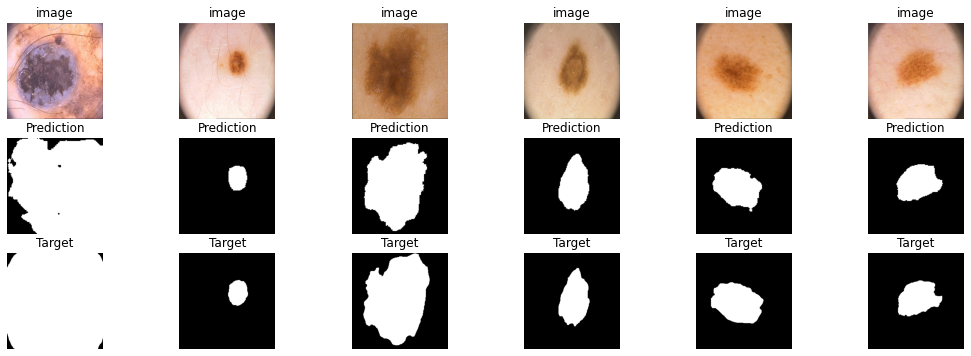

test_loss: 0.1149 test_score 0.8204


In [ ]:
test(transf_unet_fpn, loss_fn, iou_pytorch, dl_test) 

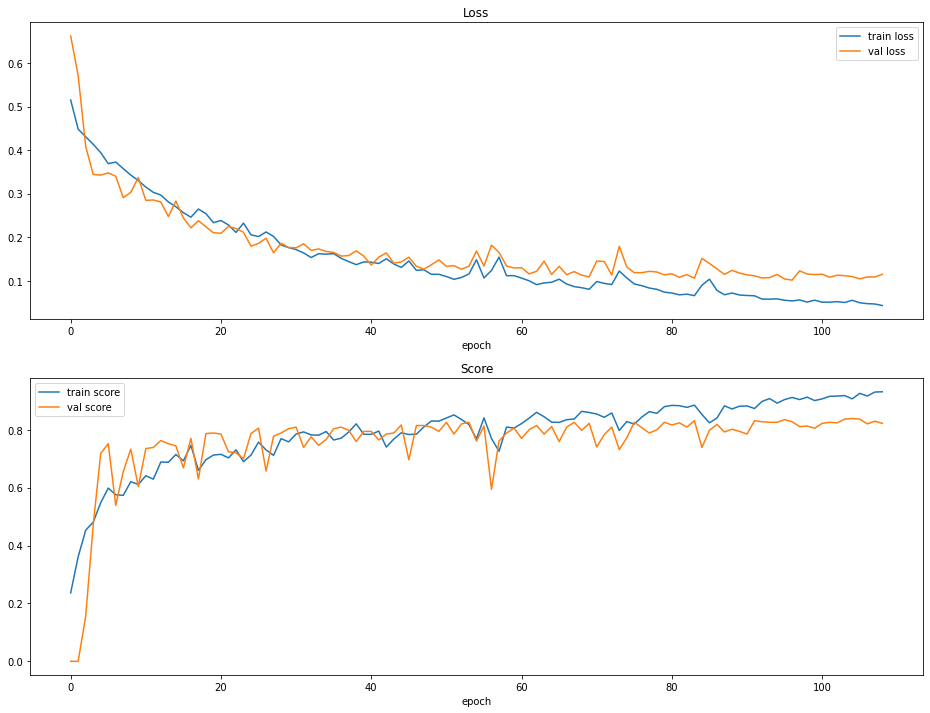

In [ ]:
plot_trainig(*history_unet_transform)

In [ ]:
test(transf_unet_fpn, loss_fn, iou_pytorch, dl_test, show=False) 

test_loss: 0.1149 test_score 0.8204


 А теперь стандартная Unet_FPN

In [ ]:
class UNet_FPN(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc0 = self.enc_block(3, 32)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) 
        self.enc1 = self.enc_block(32, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc2 = self.enc_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc3 = self.enc_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.bottleneck_conv = self.bottleneck(256, 256)

        self.fpn_0 = self.fpn_block(256, 4)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec0 = self.dec_block(256 * 2, 128)

        self.fpn_1 = self.fpn_block(128, 4)
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec1 = self.dec_block(128 * 2, 64)

        self.fpn_2 = self.fpn_block(64, 4)
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec2 = self.dec_block(64 * 2, 32)
        
        self.fpn_3 = self.fpn_block(32, 4)
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.out = nn.Conv2d(16, 1, 1, 1)

    def forward(self, x):
        # encoder
        e0 = self.enc0(x)  
        e0_pool, ind0 = self.pool0(e0) 
        
        e1 = self.enc1(e0_pool) 
        e1_pool, ind1 = self.pool1(e1) 
        
        e2 = self.enc2(e1_pool) 
        e2_pool, ind2 = self.pool2(e2) 

        e3 = self.enc3(e2_pool)
        e3_pool, ind3 = self.pool3(e3) 

        b = self.bottleneck_conv(e3_pool) 

        # decoder 
        fn0 = self.fpn_0(b)
        d0 = self.upsample0(b, ind3)
        d0 = self.dec0(torch.cat([e3, d0], 1))  

        fn1 = self.fpn_1(d0)
        d1 = torch.cat([e2, self.upsample1(d0, ind2)], 1)
        d1 = self.dec1(d1)

        fn2 = self.fpn_2(d1)
        d2 = torch.cat([e1, self.upsample2(d1, ind1)], 1)    
        d2 = self.dec2(d2) 
        
        fn3 = self.fpn_3(d2)
        d3 = torch.cat([e0, self.upsample3(d2, ind0)], 1)
           
        out = torch.cat([F.interpolate(fn0, size=256),
                         F.interpolate(fn1, size=256),
                         F.interpolate(fn2, size=256),
                         F.interpolate(fn3, size=256)], dim=1)
        out = self.out(out)    
        return out

    def bottleneck(self, in_channels, out_channels, kernel_size=3, padding=1):
        hidden_channels = in_channels // 2
        layer = nn.Sequential(            
                nn.Conv2d(in_channels, hidden_channels, kernel_size, 1, padding),
                nn.BatchNorm2d(hidden_channels),
                nn.ReLU(),
                nn.Conv2d(hidden_channels, out_channels, kernel_size, 1, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
                )
        return layer


    def enc_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        enc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, 1, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return enc

        
    def dec_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        dec = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 2, kernel_size, 1, padding),
                nn.BatchNorm2d(out_channels * 2),
                nn.ReLU(),
                nn.Conv2d(out_channels * 2, out_channels, kernel_size, 1, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU())
        return dec
    
    def fpn_block(self, in_channels, out_channels=4):
        enc = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        return enc

In [ ]:
# del(transf_unet_fpn)
np.random.seed(0)
torch.set_deterministic(True)
torch.manual_seed(0)
history_standart = ([],[],[],[])

def extend_history(history_full, history, reset=False):
    for i in range(len(history_full)):
      if reset:
          history_full[i].clear()
      history_full[i].extend(history[i])

unet_standart = UNet_FPN().to(device)
opt = torch.optim.AdamW(unet_standart.parameters(), lr=3e-4, weight_decay=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
start = time()
history = train(unet_standart, opt, loss_fn, iou_pytorch, 0, 60, dl_train, dl_val)
print('Time of execution : ', time() - start)


Epoch   1 train_loss: 0.4461 val_loss 0.6325 train_score 0.3716 val_score 0.0000

Epoch   2 train_loss: 0.3738 val_loss 0.5411 train_score 0.4456 val_score 0.0000

Epoch   3 train_loss: 0.3611 val_loss 0.3917 train_score 0.5211 val_score 0.2333

Epoch   4 train_loss: 0.3574 val_loss 0.2728 train_score 0.4882 val_score 0.6185

Epoch   5 train_loss: 0.3383 val_loss 0.2974 train_score 0.4922 val_score 0.5593

Epoch   6 train_loss: 0.3329 val_loss 0.2958 train_score 0.5775 val_score 0.5556

Epoch   7 train_loss: 0.3150 val_loss 0.2696 train_score 0.5392 val_score 0.5704

Epoch   8 train_loss: 0.2937 val_loss 0.2995 train_score 0.5946 val_score 0.6426

Epoch   9 train_loss: 0.3098 val_loss 0.2956 train_score 0.5201 val_score 0.6796

Epoch  10 train_loss: 0.2943 val_loss 0.2577 train_score 0.5740 val_score 0.6407

Epoch  11 train_loss: 0.2795 val_loss 0.2342 train_score 0.6441 val_score 0.6667

Epoch  12 train_loss: 0.2596 val_loss 0.2467 train_score 0.6480 val_score 0.7148

Epoch  13 train

In [ ]:
extend_history(history_standart, history)
opt = torch.optim.AdamW(unet_standart.parameters(), lr=3e-5, weight_decay=1e-3)
history = train(unet_standart, opt, loss_fn, iou_pytorch, 61, 80, dl_train, dl_val)


Epoch  62 train_loss: 0.0690 val_loss 0.1294 train_score 0.9069 val_score 0.8037

Epoch  63 train_loss: 0.0676 val_loss 0.1234 train_score 0.9221 val_score 0.8204

Epoch  64 train_loss: 0.0619 val_loss 0.1241 train_score 0.9196 val_score 0.8148

Epoch  65 train_loss: 0.0654 val_loss 0.1208 train_score 0.9152 val_score 0.8185

Epoch  66 train_loss: 0.0612 val_loss 0.1218 train_score 0.9260 val_score 0.8130

Epoch  67 train_loss: 0.0577 val_loss 0.1196 train_score 0.9299 val_score 0.8241

Epoch  68 train_loss: 0.0586 val_loss 0.1226 train_score 0.9279 val_score 0.8130

Epoch  69 train_loss: 0.0614 val_loss 0.1246 train_score 0.9289 val_score 0.8204

Epoch  70 train_loss: 0.0577 val_loss 0.1245 train_score 0.9314 val_score 0.8185

Epoch  71 train_loss: 0.0595 val_loss 0.1248 train_score 0.9314 val_score 0.8204

Epoch  72 train_loss: 0.0596 val_loss 0.1225 train_score 0.9363 val_score 0.8222

Epoch  73 train_loss: 0.0547 val_loss 0.1269 train_score 0.9324 val_score 0.8241

Epoch  74 train

In [ ]:
extend_history(history_standart, history)
print_best_epoch(history_standart)

best epoch    min val loss   max val score
        66          0.1196          0.8241
        79          0.1237          0.8278


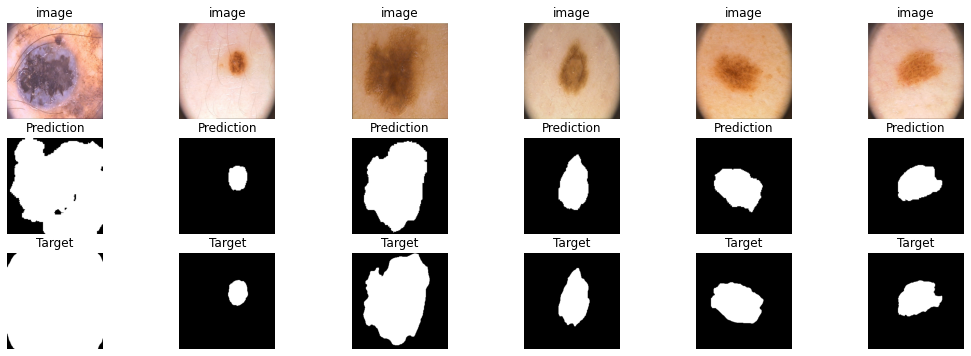

test_loss: 0.1077 test_score 0.8370


In [ ]:
test(unet_standart, loss_fn, iou_pytorch, dl_test) 

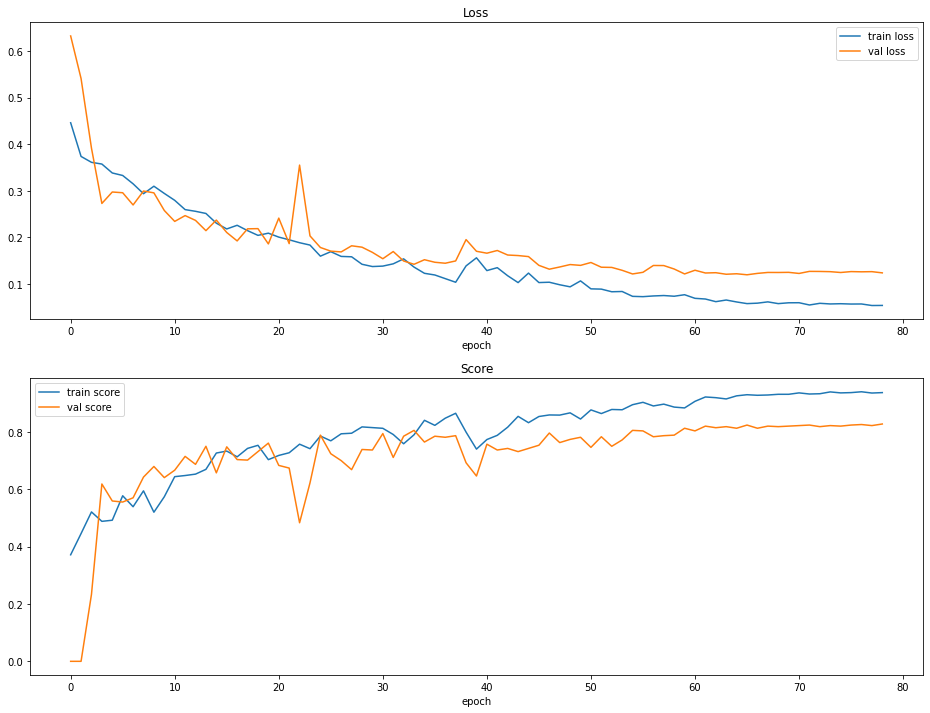

In [ ]:
plot_trainig(*history_standart)

In [ ]:
test(unet_standart, loss_fn, iou_pytorch, dl_test, show=False) 

test_loss: 0.1077 test_score 0.8370
